In [1]:
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings("ignore")
from pipeline.label_pipeline import FairnessLabelPipeline
from fairness_label.fairness_label import *
from visualization.visualize_plots import *
%matplotlib inline

# Experiment: German Credit 

In [24]:
data_file = "data/german_AIF.csv"
y_col = "credit"
y_posi = ["good"]
sensi_atts = ["age", "sex"]
sensi_pro_valus = {"age": ["young"], "sex": ["female"]}

In [3]:
base_steps = [("BalanceTargetSplitter", [0.7, 0.3], y_col), # splitter
               None,  # sampler
               None, #("DropNAImputer", "?"), # imputer
               None, # scaler
               None, # categorizer
               None,  # encoder
               None, # sensitive att and target encoder
               None,  # fair-preprocessor
               ("OPT_LogisticRegression", y_col), # model
               None  # fair-post-postprocessor
               ]

cur_pip = FairnessLabelPipeline(data_file, y_col, y_posi, sensitive_atts=sensi_atts, protected_values=sensi_pro_valus)
before_test, after_test = cur_pip.run_pipeline(base_steps, return_test=True, output_interdata=True)

BalanceTargetSplitter(input_df, [0.7, 0.3], 'credit')
!!!!!!! train (700, 21) !!!!!!!
Current train data after BalanceTargetSplitter 
 Stored in  /Users/keyang/pycharmprojects/FairnessLabelsForMLPipeline/data/inter_data/ge_BalanceTargetSplitter_OPT_LogisticRegression/train/german_AIF__after__BalanceTargetSplitter.csv

!!!!!!! test (300, 21) !!!!!!!
Current test data after BalanceTargetSplitter 
 Stored in  /Users/keyang/pycharmprojects/FairnessLabelsForMLPipeline/data/inter_data/ge_BalanceTargetSplitter_OPT_LogisticRegression/test/german_AIF__after__BalanceTargetSplitter.csv

Done Splitter

!!!!!!! train (700, 21) !!!!!!!
Current train data after BalanceTargetSplitte DropNAImpute 
 Stored in  /Users/keyang/pycharmprojects/FairnessLabelsForMLPipeline/data/inter_data/ge_BalanceTargetSplitter_OPT_LogisticRegression/train/german_AIF__after__BalanceTargetSplitte__DropNAImpute.csv

!!!!!!! test (300, 21) !!!!!!!
Current test data after BalanceTargetSplitte DropNAImpute 
 Stored in  /Users/ke

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.0s finished


!!!!!!! train (700, 22) !!!!!!!
Current train data after BalanceTargetSplitte OPT_LogisticRegression 
 Stored in  /Users/keyang/pycharmprojects/FairnessLabelsForMLPipeline/data/inter_data/ge_BalanceTargetSplitter_OPT_LogisticRegression/train/german_AIF__after__BalanceTargetSplitte__OPT_LogisticRegression.csv

!!!!!!! test (300, 22) !!!!!!!
Current test data after BalanceTargetSplitte OPT_LogisticRegression 
 Stored in  /Users/keyang/pycharmprojects/FairnessLabelsForMLPipeline/data/inter_data/ge_BalanceTargetSplitter_OPT_LogisticRegression/test/german_AIF__after__BalanceTargetSplitte__OPT_LogisticRegression.csv

Done model



## Show fairness label

In [4]:
sl_age = get_static_label(after_test, [sensi_atts[0]], y_col)
sl_age

{'old': {'bad': 0.767, 'good': 0.848}, 'young': {'bad': 0.233, 'good': 0.152}}

In [5]:
sl_age_sex = get_static_label(after_test, sensi_atts, y_col)
sl_age_sex

{('old', 'female'): {'bad': 0.29, 'good': 0.208},
 ('old', 'male'): {'bad': 0.71, 'good': 0.792},
 ('young', 'female'): {'bad': 0.667, 'good': 0.625},
 ('young', 'male'): {'bad': 0.333, 'good': 0.375}}

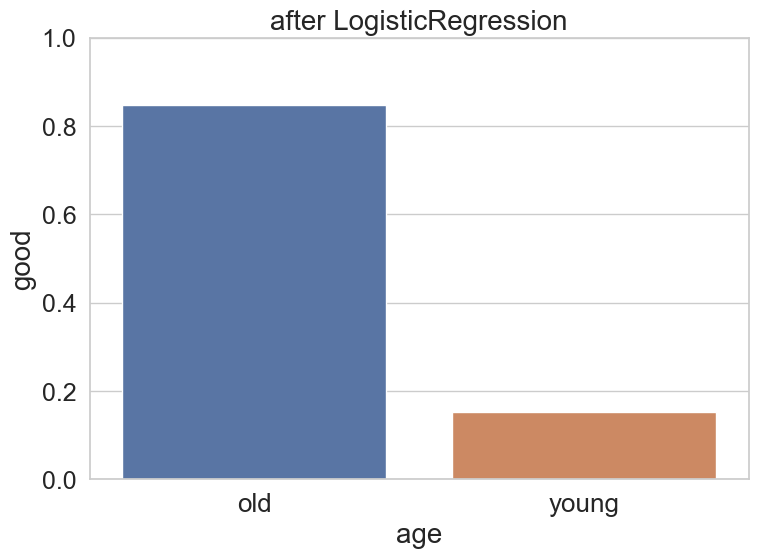

In [6]:
draw_bar_plot(sl_age, y_posi[0], [sensi_atts[0]], "LogisticRegression")

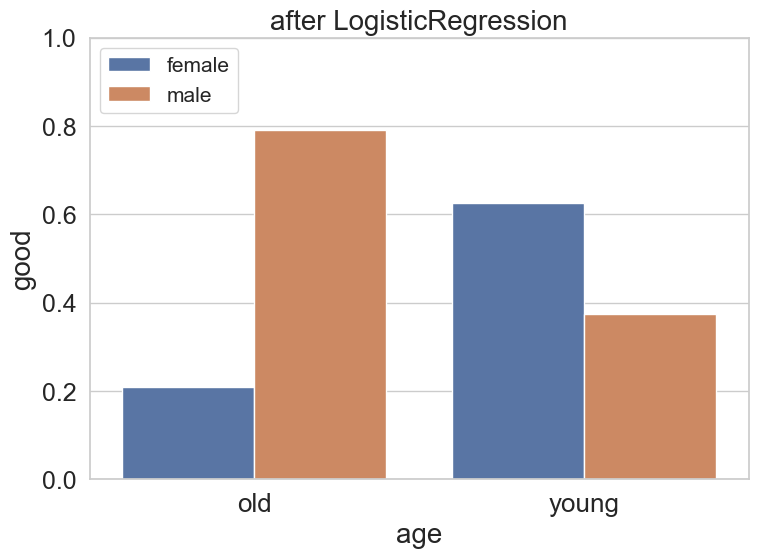

In [7]:
draw_bar_plot(sl_age_sex, y_posi[0], sensi_atts, "LogisticRegression")

In [8]:
pl_age = get_performance_label(after_test, [sensi_atts[0]], y_col, y_posi[0])
pl_age

{'old': {'PR': 0.279, 'TPR': 0.0, 'TNR': 1.0, 'FPR': 0.0, 'FNR': 1.0},
 'young': {'PR': 0.396, 'TPR': 0.0, 'TNR': 1.0, 'FPR': 0.0, 'FNR': 1.0}}

In [9]:
pl_age_sex = get_performance_label(after_test, sensi_atts, y_col, y_posi[0])
pl_age_sex

{('old', 'female'): {'PR': 0.351,
  'TPR': 0.0,
  'TNR': 1.0,
  'FPR': 0.0,
  'FNR': 1.0},
 ('old', 'male'): {'PR': 0.258,
  'TPR': 0.0,
  'TNR': 1.0,
  'FPR': 0.0,
  'FNR': 1.0},
 ('young', 'female'): {'PR': 0.412,
  'TPR': 0.0,
  'TNR': 1.0,
  'FPR': 0.0,
  'FNR': 1.0},
 ('young', 'male'): {'PR': 0.368,
  'TPR': 0.0,
  'TNR': 1.0,
  'FPR': 0.0,
  'FNR': 1.0}}

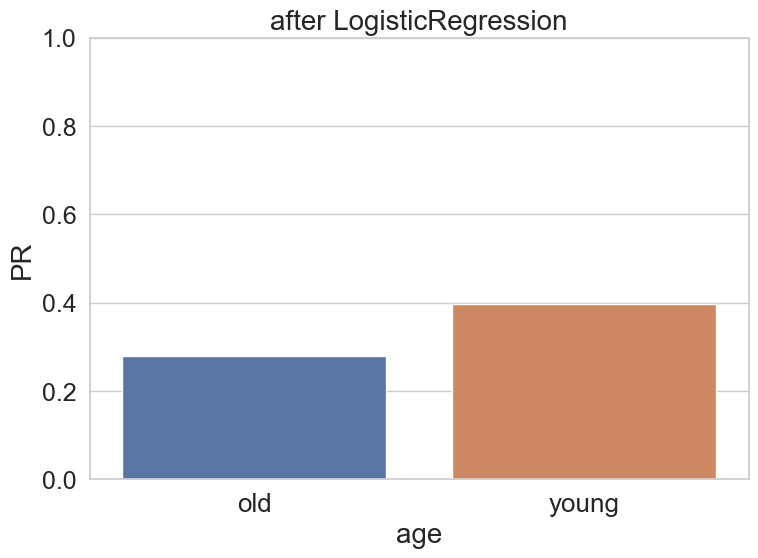

In [10]:
draw_bar_plot(pl_age, "PR", [sensi_atts[0]], "LogisticRegression")

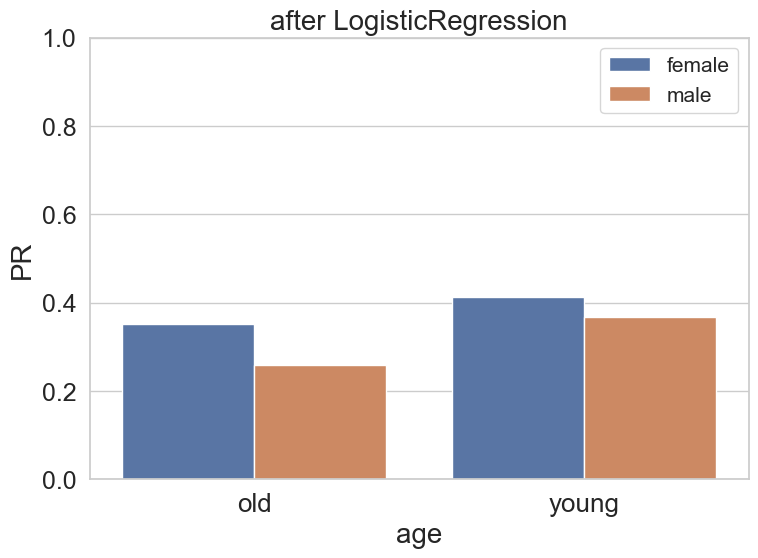

In [11]:
draw_bar_plot(pl_age_sex, "PR", sensi_atts, "LogisticRegression", True)

## Specify a pipeline with imputation and fairness postprocess interventions - equalized odds

In [18]:
debias_focus_att = "age"
fair_steps = [("BalanceTargetSplitter", [0.5, 0.3, 0.2], y_col),
               None,  # sampler
               None, #("ModeImputer", [], ["workclass"], "?"), # imputer
               None, # scaler
               None, # categorizer
               None,  # encoder
               None,
               None, #("AIF_Reweighing", y_col, debias_focus_att),  # fair-preprocessor
               ("OPT_LogisticRegression", y_col), # model
               ("AIF_EqOddsPostprocessing", y_col, debias_focus_att)  # fair-post-postprocessor
               ]

cur_pip = FairnessLabelPipeline(data_file, y_col, y_posi, sensitive_atts=sensi_atts, protected_values=sensi_pro_valus)
_, after_test_fair = cur_pip.run_pipeline(fair_steps, return_test=True, output_interdata=True)


BalanceTargetSplitter(input_df, [0.5, 0.3, 0.2], 'credit')
!!!!!!! train (500, 21) !!!!!!!
Current train data after BalanceTargetSplitter 
 Stored in  /Users/keyang/pycharmprojects/FairnessLabelsForMLPipeline/data/inter_data/ge_BalanceTargetSplitter_OPT_LogisticRegression_AIF_EqOddsPostprocessing/train/german_AIF__after__BalanceTargetSplitter.csv

!!!!!!! validation (300, 21) !!!!!!!
Current validation data after BalanceTargetSplitter 
 Stored in  /Users/keyang/pycharmprojects/FairnessLabelsForMLPipeline/data/inter_data/ge_BalanceTargetSplitter_OPT_LogisticRegression_AIF_EqOddsPostprocessing/validation/german_AIF__after__BalanceTargetSplitter.csv

!!!!!!! test (200, 21) !!!!!!!
Current test data after BalanceTargetSplitter 
 Stored in  /Users/keyang/pycharmprojects/FairnessLabelsForMLPipeline/data/inter_data/ge_BalanceTargetSplitter_OPT_LogisticRegression_AIF_EqOddsPostprocessing/test/german_AIF__after__BalanceTargetSplitter.csv

Done Splitter

!!!!!!! train (500, 21) !!!!!!!
Current t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.8s finished


!!!!!!! train (500, 22) !!!!!!!
Current train data after BalanceTargetSplitte OPT_LogisticRegression 
 Stored in  /Users/keyang/pycharmprojects/FairnessLabelsForMLPipeline/data/inter_data/ge_BalanceTargetSplitter_OPT_LogisticRegression_AIF_EqOddsPostprocessing/train/german_AIF__after__BalanceTargetSplitte__OPT_LogisticRegression.csv

!!!!!!! validation (200, 22) !!!!!!!
Current validation data after BalanceTargetSplitte OPT_LogisticRegression 
 Stored in  /Users/keyang/pycharmprojects/FairnessLabelsForMLPipeline/data/inter_data/ge_BalanceTargetSplitter_OPT_LogisticRegression_AIF_EqOddsPostprocessing/validation/german_AIF__after__BalanceTargetSplitte__OPT_LogisticRegression.csv

!!!!!!! test (200, 22) !!!!!!!
Current test data after BalanceTargetSplitte OPT_LogisticRegression 
 Stored in  /Users/keyang/pycharmprojects/FairnessLabelsForMLPipeline/data/inter_data/ge_BalanceTargetSplitter_OPT_LogisticRegression_AIF_EqOddsPostprocessing/test/german_AIF__after__BalanceTargetSplitte__OPT_Logi

In [19]:
pl_age_fair = get_performance_label(after_test_fair, [sensi_atts[0]], y_col, y_posi[0])
pl_age_fair

{'old': {'PR': 0.281, 'TPR': 1.0, 'TNR': 0.0, 'FPR': 1.0, 'FNR': 0.0},
 'young': {'PR': 0.375, 'TPR': 1.0, 'TNR': 0.04, 'FPR': 0.96, 'FNR': 0.0}}

In [20]:
pl_age_sex_fair = get_performance_label(after_test_fair, sensi_atts, y_col, y_posi[0])
pl_age_sex_fair

{('old', 'female'): {'PR': 0.231,
  'TPR': 1.0,
  'TNR': 0.0,
  'FPR': 1.0,
  'FNR': 0.0},
 ('old', 'male'): {'PR': 0.298,
  'TPR': 1.0,
  'TNR': 0.0,
  'FPR': 1.0,
  'FNR': 0.0},
 ('young', 'female'): {'PR': 0.435,
  'TPR': 1.0,
  'TNR': 0.077,
  'FPR': 0.923,
  'FNR': 0.0},
 ('young', 'male'): {'PR': 0.294,
  'TPR': 1.0,
  'TNR': 0.0,
  'FPR': 1.0,
  'FNR': 0.0}}

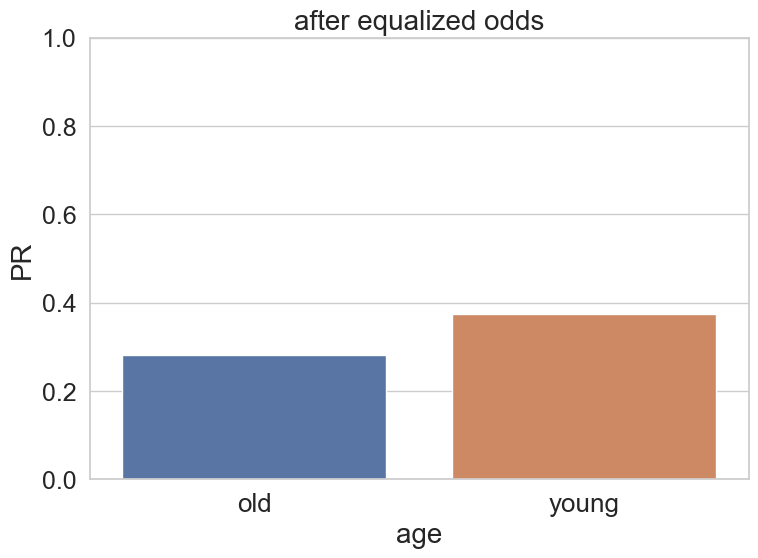

In [22]:
draw_bar_plot(pl_age_fair, "PR", [sensi_atts[0]], "equalized odds")

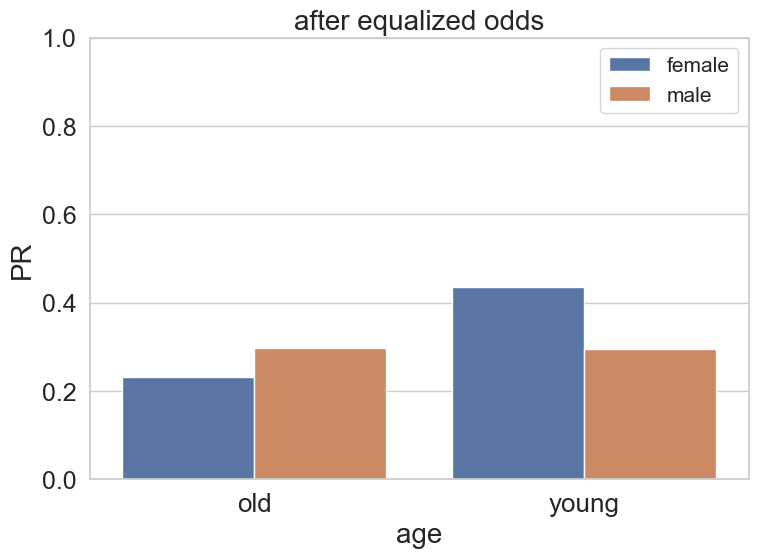

In [23]:
draw_bar_plot(pl_age_sex_fair, "PR", sensi_atts, "equalized odds", True)